In [37]:
import numpy as np
import time
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'size'   : 24}

plt.rc('font', **font)

## Creating the initial optic

We start with creating a conical lens defaulted to be a parabola (k=-1) with N=1000 points to span the space of the top half of the lens. One can start with other conical shapes by inputting the corresponding k value. The inputs are `thick` or the thickness of the lens and `R` which is the radius of curvature. The code only simulates the top half of the optic due to the assumption that the surface is cylindrically symmetric. The equation of the optic is derived from the equation for a conic section with the apex at the origin and solving for r:

\begin{align}
    r^2-2Rz+(K+1)z^2=0\\
    r=\sqrt{2Rz+(K+1)z^2}
\end{align}

One can plug in:
- k=-1 for parabola
- k=0 for spherical
- k>0 for oblate ellipse
- 0>K>−1 for prolate ellipse
- k<-1 for hyperbola

When plugging in the the values for `thick` and `R` one should keep in mind the thin lens approximation where the thickness << R

In [2]:
def create_starting_optic(thick,R,k=-1,N=100):
    z=np.geomspace(1e-6,thick,N) #solves the problem of not having enough points close to the origin
    r=np.sqrt(2*R*z-(k+1)*z**2) 
    optic=np.array([z,r])
    return optic

## Finding the slope for refraction/reflection

The goal of this is to find the normal to any shaped surface. The normal slope will be 1/m for reflected and -1/m for refracted where m is the tangent/slope of the surface at that point. 

**8/31/2022:**

Cubic spline doesn't work if the x coordinates(in our case the z coordinate) is not in ascending order. The easy fix is to rotate the system since the r coordinate of the optic is always ascending and then rotate it back for visual purposes. To rotate a coordinate system by 90 degrees: (x,y)$\rightarrow$(-y,x). 

In [3]:
def find_local_eq(r,optic,N=100):
    # first find nearest point in the lens array to where the ray r intersects
    z=optic[0]
    opt=optic[1]
    index=np.abs(opt-r).argmin()
    
    # isolate a few points around the closest index (look into how many points we actually want)
    lower=index-5
    upper=index+5
        
    local_z=np.array(z[lower:upper])
    local_opt=np.array(opt[lower:upper])-r
    
    local_z=local_z[::-1]
    local_opt=-1*local_opt[::-1]
    # Use cubic spline to interpolate the local points
    # need to switch the z and the r coordinates so that cubic spline won't give error
    cs=None
    try:
        cs=CubicSpline(local_opt,local_z)
    except:
        print(local_opt)
        print(lower)
        print(upper)
    #zs=np.linspace(local_z[0],local_z[-1],N) 
    return cs

In [4]:
def find_norm(z,cs):
    # find the normal to the surface
    tang=cs(z,1) # 1st derivative of the spline at point z
    norm=tang
    return norm

`find_reflect_slope` takes the given normal slope to calculate the angle 2$\theta$ where $\theta$ is the angle that the incoming ray makes with the normal to the surface. 

In [5]:
def find_reflect_slope(norm):
    theta=np.arctan(norm)
    slope=np.tan(2*theta)
    return slope

`find__refract_slope` finds the slope of the ray after it refracts off of the surface. `norm` is the normal of the surface and is used to find the angle $\phi_1$ which is the angle between the incident ray and the normal of the surface. This function returns the slope of the ray that refracts after encountering the surface using Snell's law 

In [6]:
def find_refract_slope(norm,n1,n2):
    phi1=np.arctan(norm)
    sinphi2=n1*np.sin(phi1)/n2
    phi2=np.arcsin(sinphi2)
    theta=phi1-phi2
    slope=np.tan(theta)
    return slope

## Raytracing

Now that we have the algorithm to find the slope normal to the surface we can simulate the ray propagation. We only need to calculate for two points:where the ray meets the surface the optic and where the ray crosses the optical axis. Additional functionality can be added later for multiple optics. Also need to change the input rays to be ray vectors instead. This code does both refraction and reflection.

In [7]:
def raytrace(optic, Nr=7, refract=False, linsp=True):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[5]
    r_max=opt[-10]
    
    rays=np.linspace(r_min,r_max,Nr) if linsp else np.geomspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for r in rays:
        cs=find_local_eq(r,optic)
        z_optic=cs(0)        
        norm=cs(0,1)
        slope=find_refract_slope(norm,1,3) if refract else find_reflect_slope(norm)
        z_after=(-r/slope+z_optic) # This is where the ray should intersect the z axis
        z_bef=-1 if refract else z_after*1.5 # change this so that z_bef all starts at the same z value
        z_ray=[z_bef,z_optic,z_after]
        r_ray=[r,r,0]            
        raymatrix.append([z_ray,r_ray])
        after.append(z_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [8]:
def raytrace_new(optic, exp_f, Nr=7, refract=False, linsp=True):
    #create the starting rays
    opt=optic[1]
    # make sure that the rays are bounded 
    r_min=opt[5]
    r_max=opt[-10]
    
    rays=np.linspace(r_min,r_max,Nr) if linsp else np.geomspace(r_min,r_max,Nr) #confine the rays to the diameter of the optic
    rays[rays==0]=1e-9 # if r=0 exists set to small value so we don't get infinity values
    raymatrix=[] # 3 points: before, at, after the optic
    after=[]
    for r in rays:
        cs=find_local_eq(r,optic)
        z_optic=cs(0)        
        norm=cs(0,1)
        slope=find_refract_slope(norm,1,3) if refract else find_reflect_slope(norm)
        r_after=slope*(exp_f-z_optic)+r # This is where the ray meets z=exp_f
        z_bef=-1 if refract else exp_f*1.5 # change this so that z_bef all starts at the same z value
        z_ray=[z_bef,z_optic,exp_f]
        r_ray=[r,r,r_after]            
        raymatrix.append([z_ray,r_ray])
        after.append(r_after)
        #np.concatenate(raymatrix)
    return np.array(raymatrix),np.array(after)

In [9]:
def plot(optic,raymatrix,exp_f,title, lambda0=None, norm=False,savefig=False):
    #first plot the optic:
    plt.figure(figsize=(15,10))
    opt_z=optic[0] if not norm else optic[0]/lambda0
    opt_r=optic[1] if not norm else optic[1]/lambda0
    plt.plot(opt_z,opt_r,'b',opt_z,-1*opt_r,'b')
    exp_freq=exp_f if not norm else exp_f/lambda0
    plt.axvline(x=exp_freq, color='k', linestyle='--')
    #Then plot the rays:
    for ray in raymatrix:
        ray_z=ray[0] if not norm else ray[0]/lambda0
        ray_r=ray[1] if not norm else ray[1]/lambda0
        plt.plot(ray_z,ray_r,'r',ray_z,-1*ray_r,'r')
        
    xl='z (m)' if not norm else 'z/lambda'
    yl='r (m)' if not norm else 'r/lambda'
    plt.xlabel(xl)
    plt.ylabel(yl)
    plt.title(title)
    plt.xlim((-0.01,exp_f+0.02))
    r_max=max(opt_r)+0.02
    plt.ylim((-r_max,r_max))
    if savefig:
        plt.savefig(title+".png")
    #plt.show()
    plt.close()

In [11]:
change_o=[start_o[0]+np.random.choice([-1,1],len(start_o[0]))*0.00001,start_o[1]]
rm1,af1=raytrace_new(change_o,0.05625,Nr=10,linsp=True)
plot(change_o,rm1,0.0565,'Step 1',savefig=True)

## `create_hist`
Creates a histogram of where the rays meet on the z axis after the ray encounters the optic. The function uses [Sturge's Formula](https://en.wikipedia.org/wiki/Histogram#Sturges'_formula) to calculate the number of bins. We use the Rayleigh criterion as the bin width: $\Delta\theta = 1.22\lambda/D$ 

$1.22 f\#*\lambda$ 

$f\#=f/D$
where $\lambda$ is the wavelength and $D$ is the diameter of the optic. This is calculated with the function `calc_bw`. This function also rounds to the nearest 6th decimal by default which corresponds to the nearest micrometer for the physical case we've defined later in this notebook.  We set the bin number to be odd so that we have the expected focal length bin always as our center bar (this may need to be altered). We set the range as the $[f_{exp} - \frac{1}{2}k \Delta\theta, f_{exp} + \frac{1}{2}k\Delta\theta]$. 

7/5/22

We've decided to instead use fractions of the Rayleigh Length $z_R=\frac{\pi w_0^2}{\lambda}=1/2 k w_0^2$

In [12]:
def calc_bw(lambda0,diam,dec=6):
    ang_res= 1.22*lambda0/diam # The bin width is set as the minimum resolution 
    return np.around(ang_res,dec) 

In [13]:
lambda0=1.054e-6 #m
diam=0.075 #m
calc_bw(lambda0,diam)

1.7e-05

In [14]:
def create_hist(rays_after, bin_width, plot=False, lambda0=None, norm=False, savefig=False):
    n=len(rays_after)    
    #make k odd so that we have even number of bin below and above the expected focal value
    k=int(np.ceil(np.log2(n)))+1
    if k%2==0:
        k+=1
    
    bw=bin_width if not norm else bin_width/lambda0
    exp_r=0 
    bin_low=exp_r-bw*(0.5*k)
    bin_high=exp_r+bw*(0.5*k)
    
    bins=np.linspace(bin_low,bin_high,k+1)
    
    rays = rays_after if not norm else rays_after/lambda0
    #hist=np.histogram(rays,bins)
    hist,bin_range=np.histogram(rays,bins)

    #plots the histogram
    if plot:
        fig,ax=plt.subplots(figsize=(15,10))
        ax.hist(rays,bins)
        xl='r (m)' if not norm else 'r/lambda'
        ax.set_xlabel(xl)
        ax.ticklabel_format(useOffset=False)
        ax.set_xticks(bins)
        title="Expected f: %f m" % (exp_f)
        ax.set_title(title)
        if savefig:
            plt.savefig(title+"_hist.png")

        plt.show()
    
    h=np.array(hist)
    return h

In [15]:
def create_hist_new(rays_after, bin_width, plot=False, lambda0=None, norm=False, savefig=False):
    n=len(rays_after)    
    #make k odd so that we have even number of bin below and above the expected focal value
    k=int(np.ceil(np.log2(n)))+1
    if k%2==0:
        k+=1
    
    bw=bin_width if not norm else bin_width/lambda0
    bin_low=-bw*k
    bin_high=bw*k
    
    bins=np.linspace(bin_low,bin_high,k+1)
    
    rays = rays_after if not norm else rays_after/lambda0
    #hist=np.histogram(rays,bins)
    hist,bin_range=np.histogram(rays,bins)

    #plots the histogram
    if plot:
        fig,ax=plt.subplots(figsize=(15,10))
        ax.hist(rays,bins)
        xl='r (m)' if not norm else 'r/lambda'
        ax.set_xlabel(xl)
        ax.ticklabel_format(useOffset=False)
        ax.set_xticks(bins)
        title="Expected f: %f m" % (exp_f)
        ax.set_title(title)
        if savefig:
            plt.savefig(title+"_hist.png")

        plt.show()
    
    h=np.array(hist)
    return h

In [16]:
def rms(rays_after):
    n=len(rays_after)
    return np.sqrt(1/n*np.sum(rays_after**2))

## The cost function

The cost function is the chi-square goodness-of-fit test which is shown below:

\begin{equation}
    \chi^2=\sum_{i=1}^{k}(O_i-E_i)^2
\end{equation}

where $O_i$ is the observed frequency for bin $i$ and $E_i$ is the expected frequency for bin $i$. For our case we want to have all of our rays meet at the same point i.e have them all in the same bin. Therefore, the expected frequency for all of the non zero bins will be the total number of rays. We will need to minimize the chi-square value in order to get the optimal optic. 

The cost function may need to have additional terms to include the parameters we wish to optimize

7/5/22 
- Number of rays within the histogram. Right now, we have it such that not all the rays end up in the histogram because of the range we have defined so one of the metrics can be the number of rays we want to end up in the histogram itself. We can use this to quickly descend to the desired k (around -1) and then have the chi-square further narrow it down accurately. 

In [15]:
def chi_square(hist):
    nr=np.sum(hist)
    if nr==0: nr=1 #to deal with situation where no rays end up in the bin
    Oi=hist/nr
    Ei=np.zeros(len(hist))
    index=int(np.floor(len(hist)/2))
    Ei[index]=1 #nr
    chi_square=np.sum((Oi-Ei)**2)
    return chi_square

In [17]:
def cost_function(hist,alpha,Nr):
    return chi_square(hist)+alpha*(Nr-np.sum(hist))/Nr

In [3]:
def cost_function_new(rays_after):
    return rms(rays_after)

[  1.   4.   9.  16.  25.  36.  49.  64.  81. 100.]


## The Gradient Descent Algorithm

In [18]:
def run_raytrace(o,exp_f,Nr,linsp=True):
    rm,af=raytrace_new(o,exp_f,refract=False,Nr=Nr,linsp=linsp)
    lambda0=1.054e-6 #m
    diam=0.075 #m
    bw=calc_bw(lambda0,diam)
    hist=create_hist(af,bw*10)
    h=np.array(hist)
    return h,rm,af

In [19]:
def grad(i,epsilon,optic,signs,alpha,exp_f,Nr):
    zeros=np.array([[0,0]])
    optic=np.concatenate((zeros.T,optic),axis=1)
    o_z=optic[0]
    o=optic[1]
    j=i+1
    o_z[j]=o_z[j]+signs[i]*epsilon
    h1,_=run_raytrace([o_z,o],exp_f,Nr)
    o_z[j]=o_z[j]-2*signs[i]*epsilon
    h2,_=run_raytrace([o_z,o],exp_f,Nr)

    c1=cost_function(h1,alpha,Nr)
    c2=cost_function(h2,alpha,Nr)
    return (c1-c2)

In [20]:
signs=np.random.choice([-1,1],100)
print(signs)

[-1  1 -1 -1 -1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1  1  1  1 -1  1
  1 -1 -1  1 -1 -1  1 -1 -1  1  1  1 -1 -1  1 -1 -1  1 -1  1 -1  1 -1 -1
 -1  1  1 -1 -1  1  1 -1 -1  1 -1  1 -1  1  1 -1 -1 -1 -1  1 -1  1 -1  1
  1 -1 -1 -1 -1 -1  1 -1  1 -1  1 -1 -1 -1  1 -1  1  1  1 -1 -1 -1  1 -1
 -1  1  1 -1]


In [21]:
dz=signs*5e-5
new_o=start_o[0]-dz
print(new_o)

[ 5.10000000e-05 -4.89074376e-05  5.11936927e-05  5.13041838e-05
  5.14249022e-05 -4.84432054e-05 -4.82991047e-05 -4.81416657e-05
  5.20303462e-05  5.22182800e-05  5.24236094e-05  5.26479445e-05
  5.28930447e-05 -4.68391680e-05  5.34534063e-05 -4.62269381e-05
  5.41223057e-05 -4.54961236e-05  5.49207661e-05 -4.46237558e-05
 -4.41261176e-05 -4.35824168e-05  5.70116103e-05 -4.23393780e-05
 -4.16302922e-05  5.91444283e-05  5.99908588e-05 -3.90843630e-05
  6.19260149e-05  6.30299158e-05 -3.57640036e-05  6.55537149e-05
  6.69934045e-05 -3.14336447e-05 -2.97150977e-05 -2.78374778e-05
  7.42139391e-05  7.64552401e-05 -2.10959986e-05  8.15794260e-05
  8.45024944e-05 -1.23038708e-05  9.11853745e-05 -5.00240717e-06
  9.91626794e-05  3.71329645e-06  1.08685130e-04  1.14117168e-04
  1.20052009e-04  2.65361929e-05  3.36205690e-05  1.41360692e-04
  1.49817260e-04  5.90565878e-05  6.91511306e-05  1.80180049e-04
  1.92229830e-04  1.05394969e-04  2.19778705e-04  1.35493835e-04
  2.52663595e-04  1.71422

In [22]:
print(new_o-start_o[0])

[ 5.e-05 -5.e-05  5.e-05  5.e-05  5.e-05 -5.e-05 -5.e-05 -5.e-05  5.e-05
  5.e-05  5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05
  5.e-05 -5.e-05 -5.e-05 -5.e-05  5.e-05 -5.e-05 -5.e-05  5.e-05  5.e-05
 -5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05  5.e-05 -5.e-05 -5.e-05 -5.e-05
  5.e-05  5.e-05 -5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05  5.e-05
 -5.e-05  5.e-05  5.e-05  5.e-05 -5.e-05 -5.e-05  5.e-05  5.e-05 -5.e-05
 -5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05 -5.e-05
  5.e-05  5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05
 -5.e-05  5.e-05  5.e-05  5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05
  5.e-05 -5.e-05  5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05 -5.e-05 -5.e-05
 -5.e-05  5.e-05  5.e-05  5.e-05 -5.e-05  5.e-05  5.e-05 -5.e-05 -5.e-05
  5.e-05]


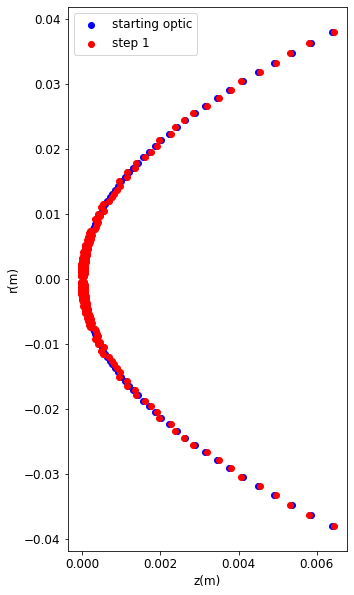

In [23]:
plt.figure(figsize=(5,10))
plt.scatter(start_o[0],start_o[1],c='b',label='starting optic')
plt.scatter(start_o[0],-1*start_o[1],c='b')

plt.scatter(new_o,start_o[1],c='r',label='step 1')
plt.scatter(new_o,-1*start_o[1],c='r')
plt.xlabel('z(m)')
plt.ylabel('r(m)')
plt.legend()
plt.savefig('step_1')
plt.show()

In [23]:
def gradient_descent(epsilon,dz,start_k,alpha,thick,roc,exp_f,learn_rate,n_iter=1000,tol=1e-12,No=100,Nr=1000,plt=False,title=None):
    start_o=create_starting_optic(thick,roc,k=start_k,N=No)
    o_r=start_o[1]
    os=[start_o[0]]
    h0,rm0,af0=run_raytrace(start_o,exp_f,Nr)
    cost=[cost_function_new(af0)]
    n=0
    if plt:
        plot(start_o,rm0,exp_f,title+"_%d"%(n),savefig=True)

    diff=1e6
    dzs=np.ones(No)*dz
    print('Step: %d\t Cost: %f'%(n,cost[0]))
    print(h0)
    o=start_o[0]
    while(n<n_iter and abs(diff)>tol):
        start_time=time.time()
        n+=1
        signs=np.random.choice([-1,1],No)
        o=o+signs*dz #move each point in the optic randomly by dz except for the point at origin
        os.append(o)
        h,rm,af=run_raytrace([o,o_r],exp_f,Nr)
        c=cost_function_new(af)
        cost.append(c)
        if plt:
            plot([o,o_r],rm,exp_f,title+"_%d"%(n),savefig=True)
        #parallel component`c`
        for i in range(len(dzs)):
            step_size=learn_rate*signs[i]*grad(i,epsilon,[o,o_r],signs,alpha,exp_f,Nr)
            dzs[i]=dzs[i]+step_size
        diff=np.sum(dz*dz)
        print('Step: %d\t Cost: %f \t diff: %E \t time: %s'%(n,c,diff,time.time()-start_time))
        print(h)
    return os,cost

In [26]:
o,c=gradient_descent(5e-6,1e-5,-0.8,1,0.0064,0.1125,0.05625,1e-4,n_iter=100,Nr=20,plt=True,title='k08_01/step')

Step: 0	 Cost: 0.045000
[ 0  0  3 17  0  0  0]
Step: 1	 Cost: 2.175000 	 diff: 1.000000E-10
[0 1 2 0 1 0 0]
Step: 2	 Cost: 0.950000 	 diff: 1.000000E-10
[0 0 0 1 0 0 0]
Step: 3	 Cost: 0.900000 	 diff: 1.000000E-10
[0 0 0 2 0 0 0]
Step: 4	 Cost: 2.950000 	 diff: 1.000000E-10
[0 0 0 0 1 0 0]
Step: 5	 Cost: 1.516667 	 diff: 1.000000E-10
[1 0 0 1 0 0 1]
Step: 6	 Cost: 2.950000 	 diff: 1.000000E-10
[0 0 1 0 0 0 0]
Step: 7	 Cost: 0.950000 	 diff: 1.000000E-10
[0 0 0 1 0 0 0]
Step: 8	 Cost: 2.950000 	 diff: 1.000000E-10
[0 0 0 0 1 0 0]
Step: 9	 Cost: 2.950000 	 diff: 1.000000E-10
[0 0 0 0 1 0 0]
Step: 10	 Cost: 2.400000 	 diff: 1.000000E-10
[1 0 0 0 0 1 0]
Step: 11	 Cost: 2.950000 	 diff: 1.000000E-10
[0 0 0 0 0 1 0]
Step: 12	 Cost: 0.950000 	 diff: 1.000000E-10
[0 0 0 1 0 0 0]
Step: 13	 Cost: 2.950000 	 diff: 1.000000E-10
[0 0 0 0 0 1 0]
Step: 14	 Cost: 2.000000 	 diff: 1.000000E-10
[0 0 0 0 0 0 0]
Step: 15	 Cost: 2.000000 	 diff: 1.000000E-10
[0 0 0 0 0 0 0]
Step: 16	 Cost: 2.000000 	 diff:

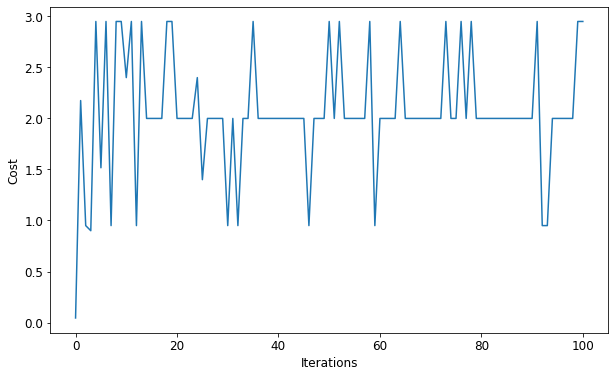

In [31]:
plt.figure(figsize=(10,6))
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.plot(c)
plt.savefig('cost')
plt.show()

## Vector version of gradient code

In [ ]:
a=np.linspace(1,10,10)
print(a)
s=np.random.choice([-1,1],len(a))
print(s)
print(np.repeat([a],len(a),axis=0)+np.multiply(np.identity(len(a)),s))

In [ ]:
def grad_new(epsilon,optic,signs,alpha,exp_f,Nr):
    o=optic[0]
    o_r=optic[1]
    o_matrix=np.repeat([o],len(o),axis=0)
    i=np.identity(len(o))
    o_plus=o_matrix+np.multiply(i,signs)*epsilon
    o_minus=o_plus-i*2*epsilon
    h1=run_raytrace([o_plus,o_r],exp_f,Nr)
    h2=run_raytrace([o_minus,o_r],exp_f,Nr)

    c1=cost_function(h1,alpha,Nr)
    c2=cost_function(h2,alpha,Nr)
    return (c1-c2)

In [ ]:
def gradient_descent_new(epsilon,dr,start_k,alpha,thick,roc,exp_f,learn_rate,n_iter=1000,tol=1e-9,No=100,Nr=1000):
    o=create_starting_optic(thick,roc,k=start_k,N=No)
    o_z=o[0]
    os=[o[1]]
    h1=run_raytrace(o,exp_f,Nr)
    cost=[cost_function(h1,alpha,Nr)]
    n=0
    diff=1e6
    drs=np.ones(No)*dr
    o=o[1]
    while(n<n_iter and abs(diff)>tol):
        signs=np.random.choice([-1,1],No)
        print(o_r)
        o=o+signs*dr #move each point in the optic randomly by dz except for the point at origin
        os.append(o)
        c=cost_function(run_raytrace([o_z,o],exp_f,Nr),alpha,Nr)
        cost.append(c)
        print(o_r)
        print('Step: %d\t Cost: %f'%(n,c))
        step_size=learn_rate*signs*grad_new(epsilon,[o_z,o],signs,alpha,exp_f,Nr)
        drs=drs+step_size
        diff=np.sum(dr*dr)
        n+=1
    return os,cost